# Using Machine Learning to classify events and baseline ("noise") datasets

In [126]:
import importlib
import logging
import pickle
import time

from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from gwpy.timeseries import TimeSeries
from matplotlib import pyplot as plt
from mne.decoding import CSP

mne_logger = logging.getLogger('mne')
mne_logger.setLevel(logging.ERROR)

In [200]:
# Local imports
import utils
import conf
import transforms as trans

importlib.reload(conf)
importlib.reload(utils)
importlib.reload(trans)

pass

In [199]:
with (conf.DATA_DIR / "X.npy").open("rb") as f:
  X = pickle.load(f)

with (conf.DATA_DIR / "y.npy").open("rb") as f:
  y = pickle.load(f)

## Data checkup/cleanup

In [129]:
# Check for damaged dataset (eg: containing NaN's).
damaged_indices = [i for i, (h1, l1) in enumerate(X)
                   if (np.isnan(h1).any() or np.isnan(l1).any())]

damaged_indices
assert len(damaged_indices) == 0

In [130]:
M = len(X) # number of records

# The actual number of features is 2*N since we have H1 and L1 strins
# for each x $\in$ X.
N = len(X[0][0]) # number of samples

M, N

(176, 131072)

# Data Visualization

In [10]:
catalog = pd.read_csv(conf.DATA_DIR / "catalog.csv")

<Figure size 432x288 with 0 Axes>

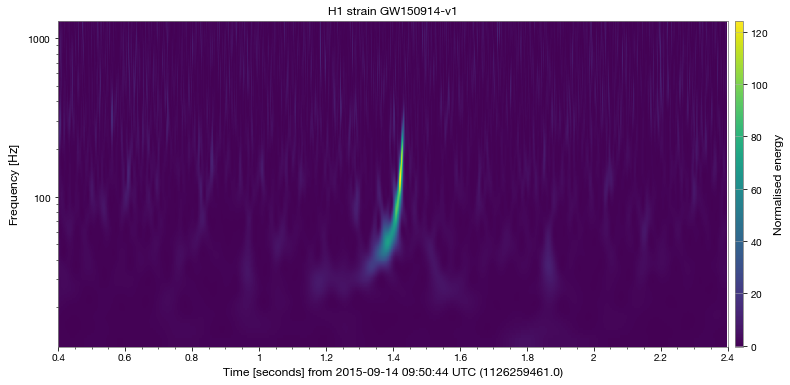

<Figure size 432x288 with 0 Axes>

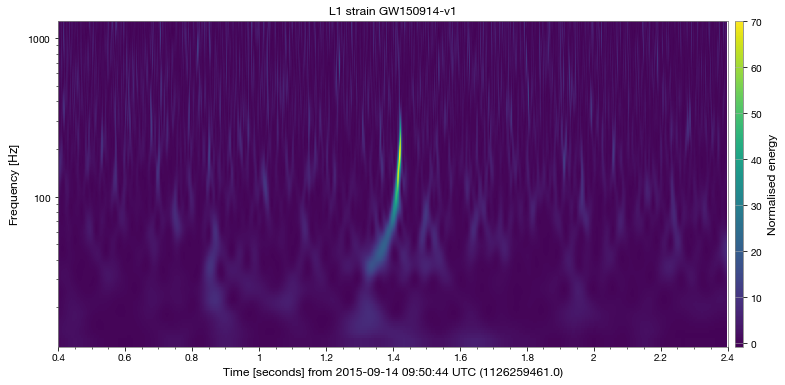

In [230]:
# Event example 1

i = 0
utils.plot_qtrans(X[i], catalog["timestamp"][i], label=catalog["event"][i])

<Figure size 432x288 with 0 Axes>

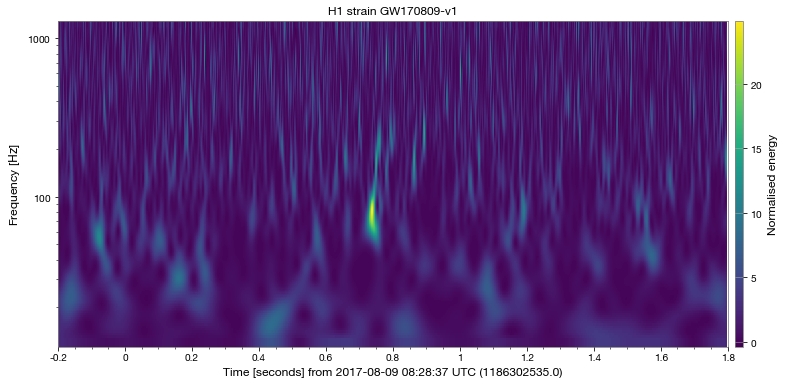

<Figure size 432x288 with 0 Axes>

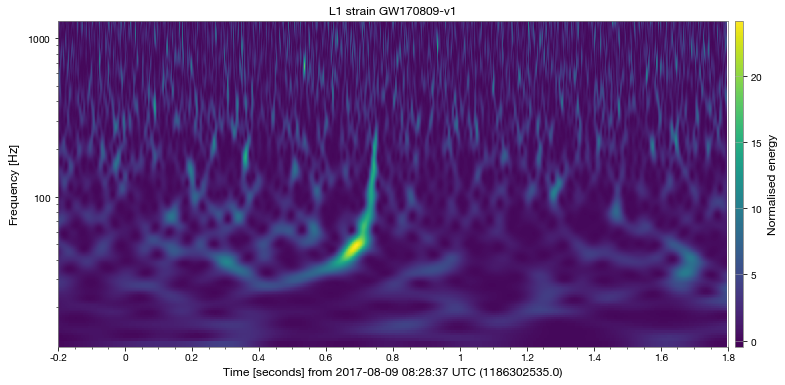

In [231]:
# Event example 2

i = 6
plot_qtrans(X[i], catalog["timestamp"][i], name=catalog["event"][i])

<Figure size 432x288 with 0 Axes>

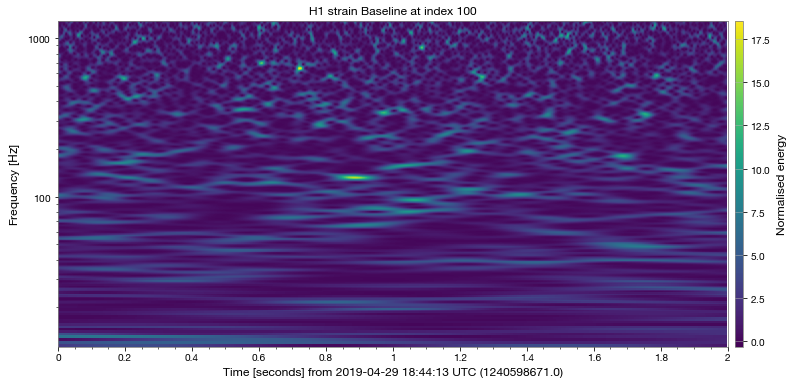

<Figure size 432x288 with 0 Axes>

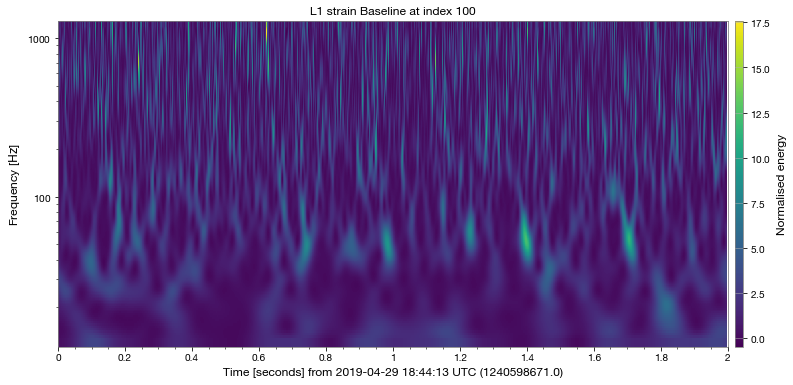

In [244]:
# Baseline example 1

i = 100
utils.plot_qtrans(X[i], label=f"Baseline at index {i}")

<Figure size 432x288 with 0 Axes>

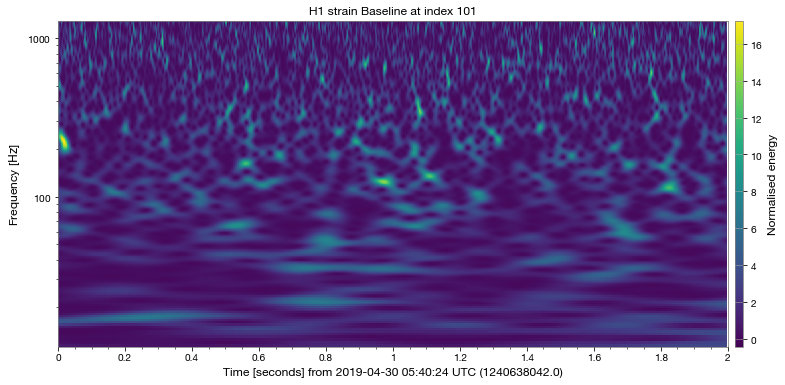

<Figure size 432x288 with 0 Axes>

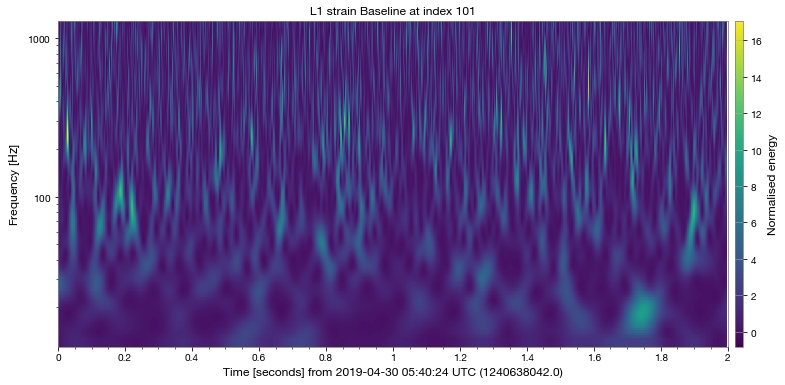

In [246]:
# Baseline example 2

i = 101
utils.plot_qtrans(X[i], label=f"Baseline at index {i}")

# Signal processing

## Example

In [131]:
catalog = pd.read_csv(conf.DATA_DIR / "catalog.csv")

In [132]:
event = 0

t = catalog["timestamp"][event]
l1s = sig = X[event][1]

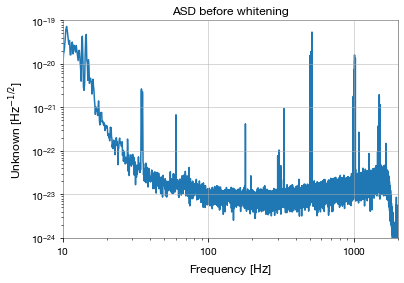

In [133]:
l1s.asd(fftlength=8).plot()
plt.title("ASD before whitening")
plt.xlim(10,2000)
plt.ylim(1e-24, 1e-19)
plt.show()
pass

(131072, 131072)

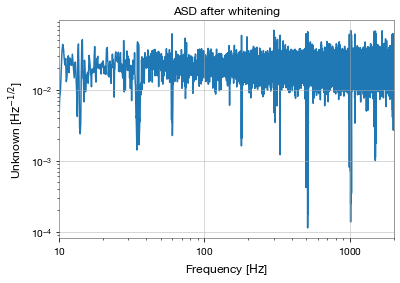

In [134]:
l1sw = l1s.whiten()
l1sw.asd(fftlength=8).plot()
plt.title("ASD after whitening")
plt.xlim(10,2000)
len(l1s), len(l1sw)

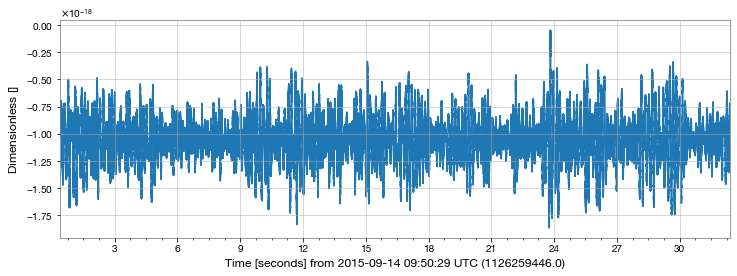

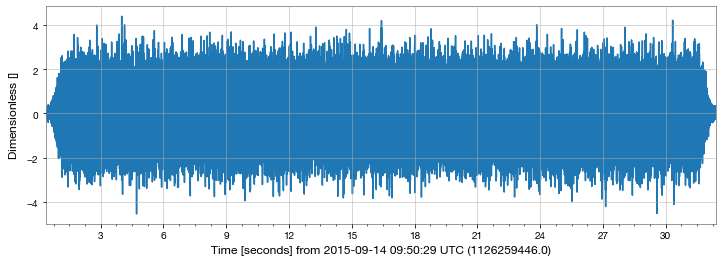

In [135]:
l1s.plot(); pass
l1sw.plot(); pass

<Figure size 432x288 with 0 Axes>

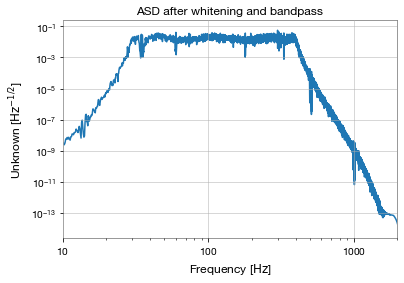

In [136]:
plt.figure()
l1s.whiten().bandpass(30, 400).asd(fftlength=8).plot()
plt.xlim(10,2000)
plt.title("ASD after whitening and bandpass")
pass

<Figure size 432x288 with 0 Axes>

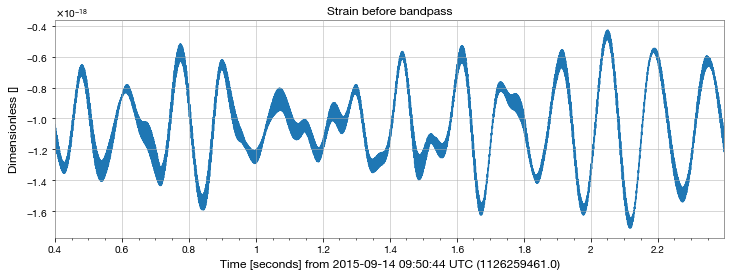

<Figure size 432x288 with 0 Axes>

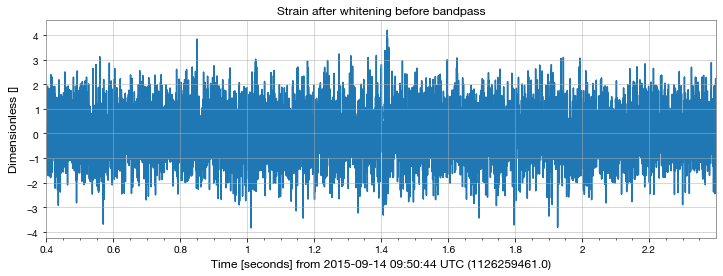

<Figure size 432x288 with 0 Axes>

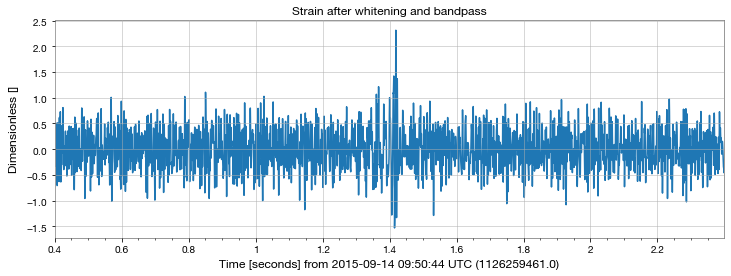

In [137]:
plt.figure()
l1s.crop(t-1, t+1).plot()
plt.title("Strain before bandpass")

plt.figure()
l1sw.crop(t-1, t+1).plot()
plt.title("Strain after whitening before bandpass")

plt.figure()
l1sw.bandpass(30, 400).crop(t-1, t+1).plot()
plt.title("Strain after whitening and bandpass")
pass

## Transform

In [186]:
%%time
filteredX = SignalFilter().transform(X)

CPU times: user 8.1 s, sys: 2.28 s, total: 10.4 s
Wall time: 10.4 s


# Classification

In [150]:
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import FunctionTransformer
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA

In [192]:
n_splits = 5
n_repeats = 10

window_length = 0.3
window_jump = 0.1
window_start = conf.dT - 1.0
window_count = 21

In [193]:
methods = {
    "csp_svm": {
      "sigfilt": True,
      "steps": (trans.NpArrayTransform, CSP(), SVC(gamma='auto')),
    },
    "csp_svm_nosigfilt": {
      "sigfilt": False,
      "steps": (trans.NpArrayTransform, CSP(), SVC(gamma='auto')),
    },
    "csp_lda": {
      "sigfilt": True,
      "steps": (trans.NpArrayTransform, CSP(), LDA()),
    },
    "csp_lda_nosigfilt": {
      "sigfilt": False,
      "steps": (trans.NpArrayTransform, CSP(), LDA()),
    }
}

In [194]:
scores = {m: [] for m in methods}

total_loops = len(methods) * window_count * n_splits * n_repeats

i = 0

initial_time = time.time()
for window_i in range(window_count):
  start = window_start + window_i * window_jump
  stop = start + window_length
  
  print("Running window:", round(start - conf.dT, 2), round(stop - conf.dT, 2))

  cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats)

  for method in methods:
    use_sigfilt = methods[method]["sigfilt"]
    steps = methods[method]["steps"]
    
    myX = filteredX if use_sigfilt else X
      
    this_scores = {m: [] for m in methods}
    for train_idx, test_idx in cv.split(y):
        # print(f"loop {i}/{total_loops}")
        train_idx_set = set(train_idx)
        test_idx_set = set(test_idx)

        X_train = [x for i, x in enumerate(myX) if i in train_idx_set]
        X_test = [x for i, x in enumerate(myX) if i in test_idx_set]

        y_train, y_test = y[train_idx], y[test_idx]
                
        clf = make_pipeline(GetWindow(start, stop),*steps)
        
        score = clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        this_scores[method].append(score)

        i += 1
    scores[method].append(np.mean(this_scores[method]))
final_time = time.time()

print("Average loop time:", (final_time - initial_time)/total_loops)

Running window: -1.0 -0.7
Running window: -0.9 -0.6
Running window: -0.8 -0.5
Running window: -0.7 -0.4
Running window: -0.6 -0.3
Running window: -0.5 -0.2
Running window: -0.4 -0.1
Running window: -0.3 0.0
Running window: -0.2 0.1
Running window: -0.1 0.2
Running window: 0.0 0.3
Running window: 0.1 0.4
Running window: 0.2 0.5
Running window: 0.3 0.6
Running window: 0.4 0.7
Running window: 0.5 0.8
Running window: 0.6 0.9
Running window: 0.7 1.0
Running window: 0.8 1.1
Running window: 0.9 1.2
Running window: 1.0 1.3
Average loop time: 0.14657044263113111


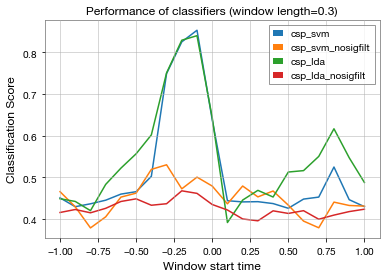

In [204]:
plt.title(f"Performance of classifiers (window length={window_length})")

plt.ylabel("Classification Score")

x_axis = np.arange(window_start - conf.dT,
               window_start - conf.dT + window_count * window_jump,
               window_jump)
plt.xlabel("Window start time")
for i, index in enumerate(scores):
  this_scores = scores[index]
  plt.plot(x_axis, this_scores, label=index)

plt.legend()
plt.savefig(conf.SCREENSHOTS_DIR / 'class_acc.jpg'); pass
pass

In [196]:
for method in methods:
  print(f"Peak classification accuracy using {method}:", max(scores[method]))

Peak classification accuracy using csp_svm: 0.8529365079365079
Peak classification accuracy using csp_svm_nosigfilt: 0.53
Peak classification accuracy using csp_lda: 0.8398571428571429
Peak classification accuracy using csp_lda_nosigfilt: 0.46750793650793654
